In [1]:
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import folium
from datetime import datetime, timedelta
from shapely.geometry import Point
from collections import Counter

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font', family='Malgun Gothic')	
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Data Loading

In [2]:
seoul_dong_boundary_geojson = gpd.read_file("~\data\서울시_행정동_경계.geojson") # 서울시 행정동 경계
seoul_dong = pd.read_csv("~\data\서울시 행정동명.csv", encoding='cp949') # 서울시 행정동명
seoul_dong_code = pd.read_csv("~\data\행정동코드.csv") # 서울시 행정동코드
seoul_population = pd.read_csv("~\data\등록인구_20250115110125.csv") # 서울시 행정동별 인구수
seoul_population['행정동명'] = seoul_population['자치구'] + ' ' + seoul_population['행정동']
seoul_population = seoul_population.drop(['행정동'], axis=1)
dui_check_cnt = pd.read_csv("~\data\자치구_단속건수.csv") # 자치구별 음주단속건수

# 1 서울시 음주운전 사고
seoul_accident_df = pd.read_csv("~\data\19_22_drunk.csv")
# 2 유흥주점, 단란주점, 일반음식점
df_yuheung = pd.read_csv(~"\data\서울시 유흥주점영업 인허가 정보.csv", encoding='cp949')
df_danran = pd.read_csv("~\data\서울시 단란주점영업 인허가 정보.csv", encoding='cp949')
df_ilban_food = pd.read_csv("~\data\서울시 일반음식점 인허가 정보.csv", encoding='utf-8')
df_ilban_food = df_ilban_food.iloc[:, :44]
# 3 자동차등록대수
car_registration = pd.read_csv("~\data\서울시 행정동별 자동차 등록대수 현황.csv", encoding='cp949').rename(columns={'읍면동 (행정동)' : '행정동'})
# 4 교차로 수
cross_roads_geojson = gpd.read_file("~\data\서울 교차로.geojson")
# 5 행정동별 유흥 지출 금액
nightlife_spending = pd.read_csv("~\data\서울시 상권분석서비스(소득소비-행정동).csv", encoding='cp949')

C:\Users\User\AppData\Local\Temp\ipykernel_28876\797151933.py:14: DtypeWarning: Columns (2,8,13,14,25,28,29,30,36,39,41,42,46,48,56,57,59,60,61,62,63,66,71,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ilban_food = pd.read_csv(r"C:\Users\User\LJS\통계청 공모전\data\서울시 일반음식점 인허가 정보.csv", encoding='utf-8')


# 2. preprocessing & feature engineering

## 2-1. 서울시 음주운전 사고

In [3]:
# 전국 사고다발지 데이터 중 서울만 필터링
seoul_accident_df = seoul_accident_df[seoul_accident_df['시도시군구명'].str.contains("서울")]

# 사고다발지 중심점의 경도 위도 추출
seoul_accident_df['geometry'] = seoul_accident_df.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
seoul_accident_df = gpd.GeoDataFrame(seoul_accident_df, geometry='geometry')
seoul_accident_df.set_crs(epsg=4326, inplace=True)

사고다발지fid  사고다발지id       법정동코드      지점코드      시도시군구명  \
0     6789498  2022051  1111017500  11110001  서울특별시 종로구1   
1     6792429  2022051  1114014300  11140001   서울특별시 중구1   
2     6792345  2022051  1114016200  11140002   서울특별시 중구2   
3     6789599  2022051  1117012800  11170001  서울특별시 용산구1   
4     6789490  2022051  1120011400  11200001  서울특별시 성동구1   
..        ...      ...         ...       ...         ...   
413   6814875  2023018  1171010100  11710002  서울특별시 송파구2   
414   6814954  2023018  1171010900  11710003  서울특별시 송파구3   
415   6814706  2023018  1174010600  11740001  서울특별시 강동구1   
416   6814850  2023018  1174010500  11740002  서울특별시 강동구2   
417   6814756  2023018  1174010900  11740003  서울특별시 강동구3   

                            지점명  사고건수  사상자수  사망자수  중상자수  경상자수  부상신고자수  \
0     서울특별시 종로구 숭인동(신설동역교차로 부근)     3     4     0     4     0       0   
1     서울특별시 중구 장충동1가(장충체육관앞 부근)     3     5     0     3     2       0   
2     서울특별시 중구 신당동(약수역서울3호선 부근)     3     5     0     3     2       0   
3    서울특별시 용산구 한강로3가(한강대교북측 부근)     3     9     0     4     5       0   
4      서울특별시 성동구 성수동1가(성수대교 부근)     4    12     0     7     5       0   
..                          ...   ...   ...   ...   ...   ...     ...   
413    서울특별시 송파구 잠실동(잠실역사거리 부근)     3     4     0     3     1       0   
414  서울특별시 송파구 장지동(복정역 앞교차로 부근)     3     4     0     3     0       1   
415     서울특별시 강동구 둔촌동(길동사거리 부근)     5    11     0     6     5       0   
416   서울특별시 강동구 길동(생태공원앞교차로 부근)     3    12     0     3     8       1   
417     서울특별시 강동구 천호동(천호사거리 부근)     3     5     0     3     2       0   

             경도         위도                                            다발지역폴리곤  \
0    127.023122  37.575433  {"type":"Polygon","coordinates":[[[127.0240199...   
1    127.005786  37.559678  {"type":"Polygon","coordinates":[[[127.0066838...   
2    127.010806  37.553750  {"type":"Polygon","coordinates":[[[127.0117045...   
3    126.960990  37.522527  {"type":"Polygon","coordinates":[[[126.9618883...   
4    127.036229  37.543578  {"type":"Polygon","coordinates":[[[127.0371277...   
..          ...        ...                                                ...   
413  127.099770  37.513669  {"type":"MultiPolygon","coordinates":[[[[127.1...   
414  127.126690  37.470311  {"type":"MultiPolygon","coordinates":[[[[127.1...   
415  127.138825  37.533625  {"type":"MultiPolygon","coordinates":[[[[127.1...   
416  127.152675  37.538200  {"type":"MultiPolygon","coordinates":[[[[127.1...   
417  127.122953  37.538803  {"type":"MultiPolygon","coordinates":[[[[127.1...   

                       geometry  
0    POINT (127.02312 37.57543)  
1    POINT (127.00579 37.55968)  
2    POINT (127.01081 37.55375)  
3    POINT (126.96099 37.52253)  
4    POINT (127.03623 37.54358)  
..                          ...  
413  POINT (127.09977 37.51367)  
414  POINT (127.12669 37.47031)  
415  POINT (127.13883 37.53362)  
416   POINT (127.15267 37.5382)  
417   POINT (127.12295 37.5388)  

[168 rows x 16 columns]

In [4]:
# 동별 건수 추출
join_df = gpd.sjoin(seoul_accident_df, seoul_dong_boundary_geojson, how='left', predicate='intersects')

In [5]:
# 동 이름 추출
dong_names = seoul_dong_boundary_geojson['adm_nm'].unique()
dong_df = pd.DataFrame(dong_names, columns=['행정동명'])
print(dong_df.shape)
print(dong_df.head())

(426, 1)
            행정동명
0  서울특별시 종로구 사직동
1  서울특별시 종로구 삼청동
2  서울특별시 종로구 부암동
3  서울특별시 종로구 평창동
4  서울특별시 종로구 무악동


In [6]:
# 행정동별 사고건수
accident_count_dong = join_df.groupby('temp')['사고건수'].sum().reset_index()

# 행정동 내 사고다발지 수
hotspot_count_dong = join_df['temp'].value_counts().reset_index().rename(columns={'count':'사고다발지 수'})

# 행정동별 사상자수
casualty_count_dong = join_df.groupby('temp')['사상자수'].sum().reset_index()

# merge
merge_temp = pd.merge(accident_count_dong, hotspot_count_dong, on='temp', how='outer')
dong_accident_df = pd.merge(merge_temp, casualty_count_dong, on='temp', how='outer').rename(columns={'temp': '행정동명'})

print(dong_accident_df.shape)
print(dong_accident_df.head())

(101, 4)
       행정동명  사고건수  사고다발지 수  사상자수
0  강남구 개포2동     3        1     4
1  강남구 논현1동    15        3    25
2  강남구 논현2동    20        6    52
3  강남구 대치2동     6        2    10
4  강남구 대치4동     6        2    11


## 2-2. 서울시 유흥주점, 단란주점, 일반음식점

- 데이터 상으로는 영업 중이지만, `최종수정일자` 컬럼이 오래된 지점을 검색해보니 없는 가게가 있음
- 이를, 폐업 지점의 폐업 인허가일자부터 폐업까지 평균 날짜를 계산하여, `최종수정일자`가 그만큼 지난 데이터는 삭제하여 처리

### 2-2-1. 유흥주점

In [7]:
active_bars = df_yuheung[df_yuheung['영업상태코드'] == 1]
closed_bars = df_yuheung[df_yuheung['영업상태코드'] == 3]

print("영업 중: ", active_bars.shape[0])
print("폐업: ", closed_bars.shape[0])


def parse_dates(date):
    if '-' in date:
        return pd.to_datetime(date, format='%Y-%m-%d')
    else:
        return pd.to_datetime(date, format='%Y%m%d')
    
    
closed_bars['인허가일자'] = closed_bars['인허가일자'].apply(parse_dates)
closed_bars['폐업일자'] = closed_bars['폐업일자'].apply(parse_dates)
closed_bars['폐업까지_기간'] = (closed_bars['폐업일자'] - closed_bars['인허가일자']).dt.days

mean_close_date = closed_bars['폐업까지_기간'].mean()
print("폐업까지 평균 기간: ", round(mean_close_date, 3))


active_bars['인허가일자'] = active_bars['인허가일자'].apply(parse_dates)
active_bars['최종수정일자'] = pd.to_datetime(active_bars['최종수정일자'])
active_bars['최종수정일자'] = active_bars['최종수정일자'].dt.date

current_date = datetime.now().date()
threshold_date = current_date - timedelta(days=mean_close_date)
filtered_df = active_bars[active_bars['최종수정일자'] < threshold_date]
print(len(filtered_df['최종수정일자']))

df_yuheung = active_bars[~(active_bars['최종수정일자'] < threshold_date)]
print(len(df_yuheung))

영업 중:  1750
폐업:  3193
폐업까지 평균 기간:  4978.356
57
1693


### 2-2-2. 단란주점

In [8]:
active_bars = df_danran[df_danran['영업상태코드'] == 1]
closed_bars = df_danran[df_danran['영업상태코드'] == 3]

print("영업 중: ", active_bars.shape[0])
print("폐업: ", closed_bars.shape[0])


def parse_dates(date):
    if '-' in date:
        return pd.to_datetime(date, format='%Y-%m-%d')
    else:
        return pd.to_datetime(date, format='%Y%m%d')
    
    
closed_bars['인허가일자'] = closed_bars['인허가일자'].apply(parse_dates)
closed_bars['폐업일자'] = closed_bars['폐업일자'].apply(parse_dates)
closed_bars['폐업까지_기간'] = (closed_bars['폐업일자'] - closed_bars['인허가일자']).dt.days

mean_close_date = closed_bars['폐업까지_기간'].mean()
print("폐업까지 평균 기간: ", round(mean_close_date, 3))


active_bars['인허가일자'] = active_bars['인허가일자'].apply(parse_dates)
active_bars['최종수정일자'] = pd.to_datetime(active_bars['최종수정일자'])
active_bars['최종수정일자'] = active_bars['최종수정일자'].dt.date

current_date = datetime.now().date()
threshold_date = current_date - timedelta(days=mean_close_date)
filtered_df = active_bars[active_bars['최종수정일자'] < threshold_date]
print(len(filtered_df['최종수정일자']))

df_danran = active_bars[~(active_bars['최종수정일자'] < threshold_date)]
print(len(df_danran))

영업 중:  1993
폐업:  9594
폐업까지 평균 기간:  2676.017
459
1534


### 2-2-3. 일반음식점

In [9]:
active_bars = df_ilban_food[df_ilban_food['영업상태코드'] == 1]
closed_bars = df_ilban_food[df_ilban_food['영업상태코드'] == 3]

active_bars['인허가일자'] = active_bars['인허가일자'].astype(str)
closed_bars['인허가일자'] = closed_bars['인허가일자'].astype(str)

# .0이 포함된 폐업일자 전처리
dot_zero_mask = closed_bars['폐업일자'].astype(str).str.endswith('.0')
df_dot_zero = closed_bars[dot_zero_mask].copy()
# .0 제거, int로 변환
df_dot_zero['폐업일자'] = df_dot_zero['폐업일자'].astype(str).str.replace('.0', '').astype(int)
# 원본 df에 반영
closed_bars.loc[dot_zero_mask, '폐업일자'] = df_dot_zero['폐업일자']

In [10]:
closed_bars['폐업일자'] = closed_bars['폐업일자'].astype(str)

active_bars['최종수정일자'] = active_bars['최종수정일자'].astype(str)
closed_bars['최종수정일자'] = closed_bars['최종수정일자'].astype(str)

def parse_dates(date):
    if '-' in date:
        return pd.to_datetime(date, format='%Y-%m-%d')
    else:
        return pd.to_datetime(date, format='%Y%m%d')

closed_bars['인허가일자'] = closed_bars['인허가일자'].apply(parse_dates)
closed_bars['폐업일자'] = closed_bars['폐업일자'].apply(parse_dates)
closed_bars['일수차이'] = (closed_bars['폐업일자'] - closed_bars['인허가일자']).dt.days
mean_close_date = closed_bars['일수차이'].mean()
print(round(mean_close_date, 3))

active_bars['인허가일자'] = active_bars['인허가일자'].apply(parse_dates)
active_bars['최종수정일자'] = pd.to_datetime(active_bars['최종수정일자'])

active_bars['최종수정일자'] = active_bars['최종수정일자'].dt.date
active_bars['최종수정일자'] = pd.to_datetime(active_bars['최종수정일자'])

2452.189


In [11]:
# 최종수정일자가 현재로부터 2452.189일 이상 지난 데이터 필터링
current_date = datetime.now().date()
threshold_date = current_date - timedelta(days=mean_close_date)

threshold_date = pd.Timestamp(threshold_date)
filtered_df = active_bars[active_bars['최종수정일자'] < threshold_date]
print(len(filtered_df['최종수정일자']))

df_ilban_food = active_bars[~(active_bars['최종수정일자'] < threshold_date)]
print(len(df_ilban_food))

26883
97918


- 행정동별로 유흥주점 수, 단란주점 수, 일반음식점 수를 서울시 행정동 경계와 spatial join 하기 위해, raw data의 좌표계 epsg5174를 epsg4326으로 변환

In [12]:
def process_location_data(df, output_csv, boundary_geojson, output_column_name):
    """
    주어진 데이터프레임에 대해 좌표 변환 및 행정동별 개수 계산을 수행하는 함수
    - df: 처리할 데이터프레임
    - output_csv: 변환 결과를 저장할 CSV 파일명
    - boundary_geojson: 행정동 경계 GeoJSON 파일
    - output_column_name: 결과 컬럼명 (예: '유흥주점수')
    """
    # 1. 좌표 데이터 정리 및 전처리
    df['좌표정보(X)'] = pd.to_numeric(df['좌표정보(X)'], errors="coerce")
    df['좌표정보(Y)'] = pd.to_numeric(df['좌표정보(Y)'], errors="coerce")
    df.dropna(subset=['좌표정보(X)', '좌표정보(Y)'], inplace=True)
    df.index = range(len(df))

    # 2. 좌표계 변환 함수 정의
    def project_array(coord, p1_type, p2_type):
        p1 = pyproj.Proj(init=p1_type)
        p2 = pyproj.Proj(init=p2_type)
        fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
        return np.dstack([fx, fy])[0]

    # 좌표 배열 준비
    coord = np.array(df[['좌표정보(X)', '좌표정보(Y)']])

    # 좌표계 변환: EPSG:5174 -> EPSG:3857
    if len(coord) > 0:
        result = project_array(coord, "epsg:5174", "epsg:3857")
        df['경도X'] = result[:, 0]
        df['위도Y'] = result[:, 1]

        # 중간 결과 저장
        df.to_csv(output_csv.replace(".csv", "toEPSG_3857.csv"), index=False, encoding='utf-8-sig')

    # 3. EPSG:3857 -> EPSG:4326 변환
    df['경도X'] = pd.to_numeric(df['경도X'], errors="coerce")
    df['위도Y'] = pd.to_numeric(df['위도Y'], errors="coerce")
    df.dropna(subset=['경도X', '위도Y'], inplace=True)
    df.index = range(len(df))

    coord = np.array(df[['경도X', '위도Y']])
    if len(coord) > 0:
        result = project_array(coord, "EPSG:3857", "EPSG:4326")
        df['경도'] = result[:, 0]
        df['위도'] = result[:, 1]

        # 최종 결과 저장
        df.to_csv(output_csv, index=False, encoding='utf-8-sig')

    # 4. GeoDataFrame 생성
    df['geometry'] = df.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
    geo_df = gpd.GeoDataFrame(df, geometry='geometry')
    geo_df.set_crs(epsg=4326, inplace=True)

    # 5. 행정동 경계와 Spatial Join
    join_df = gpd.sjoin(geo_df, boundary_geojson, how='left', predicate='intersects')

    # 필요한 컬럼 정리
    col = ['경도', '위도', 'geometry', 'temp']
    join_df = join_df[col]
    join_df = join_df.rename(columns={'temp': '행정동명'})

    # 6. 행정동별 개수 계산
    result_cnt = join_df.groupby('행정동명').size()
    result_cnt = result_cnt.sort_values(ascending=False).reset_index()
    result_cnt.columns = ['행정동명', output_column_name]

    return result_cnt

# 함수 호출 예시
boundary_geojson = seoul_dong_boundary_geojson

# 유흥주점 처리
yuheung_cnt = process_location_data(df_yuheung, "유흥업소정보_좌표변환완료.csv", boundary_geojson, "유흥주점수")

# 단란주점 처리
danran_cnt = process_location_data(df_danran, "단란업소정보_좌표변환완료.csv", boundary_geojson, "단란주점수")

# 일반음식점 처리
ilban_food_cnt = process_location_data(df_ilban_food, "일반음식점정보_좌표변환완료.csv", boundary_geojson, "일반음식점수")

c:\Users\User\anaconda3\envs\js\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\User\anaconda3\envs\js\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\User\AppData\Local\Temp\ipykernel_28876\45747257.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  f

### data merging - 행정동별 가게 수

In [13]:
store_cnt = pd.merge(ilban_food_cnt, yuheung_cnt, on='행정동명', how='left')
store_cnt['유흥주점수'] = store_cnt['유흥주점수'].fillna(0)

store_cnt = pd.merge(store_cnt, danran_cnt, on='행정동명', how='left')
store_cnt['단란주점수'] = store_cnt['단란주점수'].fillna(0)

store_cnt['유흥주점수'] = store_cnt['유흥주점수'].astype(int)
store_cnt['단란주점수'] = store_cnt['단란주점수'].astype(int)

In [14]:
store_cnt.head()

행정동명  일반음식점수  유흥주점수  단란주점수
0          마포구 서교동    2137     18     18
1         강남구 역삼1동    2094     69     39
2  종로구 종로1·2·3·4가동    1531     57     38
3         영등포구 여의동    1471     38     14
4         강서구 가양1동    1020     31      4

## 2-3. 서울시 자동차등록대수

In [15]:
# 행정동별 합계
car_cnt_df = car_registration.groupby('행정동')['계'].sum().sort_values(ascending=False)
car_cnt_df = pd.DataFrame(car_cnt_df)
car_cnt_df = car_cnt_df.reset_index()

car_cnt_df = car_cnt_df[car_cnt_df['행정동'].str.contains('기타') == False]
car_cnt_df = car_cnt_df.rename(columns={'행정동': '행정동명'}).reset_index(drop=True)

- 행정동명이 바뀌거나 일치하지 않는 행 전처리
- 상일동은 상일1동과 2동으로 나뉘어졌고, 인구 수 비율에 따라 값을 추가했음

In [16]:
missing = [
    '강남구 논현동',
    '강동구 길1동', '강동구 하일동', '강동구 상일동',
    '구로구 구로본동', '구로구 개봉본동',
    '금천구 독산1동분소',
    '노원구 월계4동', '노원구 공릉1.3동',
    '마포구 도화1동', '마포구 도화2동', '마포구 노고산동',
    '서초구 도곡동',
    '영등포구 영등포1동', '영등포구 평택시 서정동',
    '종로구 명륜3가동',
    '중구 신당1동', '중구 신당2동', '중구 신당3동', '중구 신당4동',
    '중구 신당6동', '중구 을지로3.4.5가동', '중구 남대문로5가동', '중구 태평로1가동'
]

car_cnt_df['행정동명'] = car_cnt_df['행정동명'].str.strip().str.lower()

car_cnt_df.loc[car_cnt_df['행정동명'] == '강남구 일원2동', '행정동명'] = '강남구 개포3동'

car_cnt_df.loc[car_cnt_df['행정동명'] == '강동구 길동', '계'] += 1
car_cnt_df.loc[car_cnt_df['행정동명'] == '강동구 강일동', '계'] += 7
car_cnt_df.loc[car_cnt_df['행정동명'] == '강동구 상일제1동', '계'] += 9133
car_cnt_df.loc[car_cnt_df['행정동명'] == '강동구 상일제2동', '계'] += 2077
car_cnt_df.loc[car_cnt_df['행정동명'] == '구로구 구로2동', '계'] += 40
car_cnt_df.loc[car_cnt_df['행정동명'] == '구로구 개봉1동', '계'] += 17
car_cnt_df.loc[car_cnt_df['행정동명'] == '금천구 독산1동', '계'] += 1
car_cnt_df.loc[car_cnt_df['행정동명'] == '노원구 공릉1동', '계'] += 50
car_cnt_df.loc[car_cnt_df['행정동명'] == '마포구 도화동', '계'] += 1
car_cnt_df.loc[car_cnt_df['행정동명'] == '종로구 혜화동', '계'] += 9
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 신당동', '계'] += 47
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 다산동', '계'] += 24
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 약수동', '계'] += 1
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 청구동', '계'] += 5
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 동화동', '계'] += 6
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 을지로동', '계'] += 42
car_cnt_df.loc[car_cnt_df['행정동명'] == '중구 회현동', '계'] += 1

car_cnt_df['행정동명'] = car_cnt_df['행정동명'].str.strip().str.lower()
car_cnt_df = car_cnt_df[~car_cnt_df['행정동명'].isin(missing)]
car_cnt_df = car_cnt_df.sort_values(by='계', ascending=False).reset_index(drop=True)
car_cnt_df

행정동명        계
0    강서구 가양1동  26665.0
1    강남구 역삼1동  21032.0
2    서초구 양재1동  20923.0
3    영등포구 여의동  20629.0
4     금천구 가산동  20010.0
..        ...      ...
421   종로구 가회동   1265.0
422  서초구 반포본동   1250.0
423  종로구 창신1동   1197.0
424   종로구 삼청동    777.0
425  강동구 둔촌1동    545.0

[426 rows x 2 columns]

## 2-4. 서울시 교차로 수

In [17]:
join_df = gpd.sjoin(cross_roads_geojson, seoul_dong_boundary_geojson, how='left', predicate='intersects')

In [18]:
cross_roads_cnt = join_df['temp'] # 행정동명만 남김
cross_roads_cnt = pd.DataFrame(cross_roads_cnt)

In [19]:
cross_roads_cnt = cross_roads_cnt.groupby('temp').size()
cross_roads_cnt = cross_roads_cnt.sort_values(ascending=False)
cross_roads_cnt = pd.DataFrame(cross_roads_cnt)
cross_roads_cnt.reset_index(inplace=True)
cross_roads_cnt.columns = ['행정동명', '교차로수']

In [20]:
cross_roads_cnt

행정동명  교차로수
0    영등포구 여의동    87
1     은평구 진관동    58
2     양천구 목5동    52
3     금천구 가산동    51
4    양천구 신정3동    51
..        ...   ...
420  동작구 사당4동     2
421  동작구 상도3동     2
422   종로구 교남동     2
423   종로구 무악동     1
424  종로구 창신3동     1

[425 rows x 2 columns]

## 2-5. 서울시 유흥 지출 금액 (상권분석서비스)

In [21]:
seoul_dong['행정동명'] = seoul_dong['행정동명'].apply(lambda x: x.split()[-1])
seoul_dong.head(3)

행정동명
0  사직동
1  삼청동
2  부암동

In [22]:
len(nightlife_spending['행정동_코드_명'].unique())

424

In [23]:
nightlife_spending.head()

기준_년분기_코드    행정동_코드 행정동_코드_명  월_평균_소득_금액  소득_구간_코드       지출_총금액  \
0      20231  11650652     양재2동     3222382         7  10104796000   
1      20231  11110550      부암동     3647449         7   1385759000   
2      20231  11110640      이화동     3024996         7  10622974000   
3      20231  11680660     개포1동     5336373         9    250506000   
4      20231  11110515    청운효자동     3780222         8   2784933000   

   식료품_지출_총금액  의류_신발_지출_총금액  생활용품_지출_총금액  의료비_지출_총금액  교통_지출_총금액   교육_지출_총금액  \
0  2222160000     152143000     70918000  1817290000  801723000   259544000   
1   232200000      39726000     12611000   101703000  109837000    78943000   
2  1035923000     213685000     41488000  2776380000   30454000  2965305000   
3    70320000       8632000      1380000   134557000          0    18870000   
4   880544000     197642000     57935000   121901000   25568000    53711000   

   유흥_지출_총금액  여가_문화_지출_총금액  기타_지출_총금액   음식_지출_총금액  
0  192584000    1093403000  152287000  3342744000  
1    2652000     131748000    6197000   670142000  
2  176154000     207416000  181317000  2994852000  
3          0             0    5140000    11607000  
4   86449000     171279000   67694000  1122210000

In [24]:
nightlife_spending['행정동_코드_명'] = nightlife_spending['행정동_코드_명'].replace('\?', '·', regex=True)

In [25]:
def clean_name(name):
    if "홍제" in name:
        return re.sub(r'(홍제)제', r'\1', name)  # '홍제제'를 '홍제'로 바꿈
    elif "제기" in name:
        return name  # 제기동은 그대로 유지
    else:
        return name.replace('제', '')
    
tmp1 = seoul_dong_code.groupby(['행정동코드', '행정동명']).size()
tmp1 = pd.DataFrame(tmp1)
tmp1 = tmp1.reset_index().drop([0], axis=1)

tmp1['행정동명'] = tmp1['행정동명'].apply(clean_name)

tmp1.loc[tmp1['행정동명'] == '구로구 수궁동', '행정동코드'] = '99999999' # 오류2동과 수궁동 코드가 똑같기 때문에 임시로 처리
tmp1.loc[tmp1['행정동명'] == '강남구 일원2동', '행정동명'] = '강남구 개포3동'
tmp1.loc[tmp1['행정동명'] == '노원구 공릉1.3동', '행정동명'] = '노원구 공릉1동'
tmp1.loc[tmp1['행정동명'] == '노원구 공릉1동', '행정동코드'] = '11350595'
tmp1.loc[tmp1['행정동명'] == '중구 신당1동', '행정동명'] = '중구 신당동'
tmp1.loc[tmp1['행정동명'] == '중구 신당동', '행정동코드'] = '11140615'
tmp1.loc[tmp1['행정동명'] == '중구 신당2동', '행정동명'] = '중구 다산동'
tmp1.loc[tmp1['행정동명'] == '중구 다산동', '행정동코드'] = '11140625'
tmp1.loc[tmp1['행정동명'] == '중구 신당3동', '행정동명'] = '중구 약수동'
tmp1.loc[tmp1['행정동명'] == '중구 약수동', '행정동코드'] = '11140635'
tmp1.loc[tmp1['행정동명'] == '중구 신당4동', '행정동명'] = '중구 청구동'
tmp1.loc[tmp1['행정동명'] == '중구 청구동', '행정동코드'] = '11140645'
tmp1.loc[tmp1['행정동명'] == '중구 신당6동', '행정동명'] = '중구 동화동'
tmp1.loc[tmp1['행정동명'] == '중구 동화동', '행정동코드'] = '11140665'
tmp1.loc[tmp1['행정동명'] == '강북구 번1동', '행정동코드'] = '11305595'
tmp1.loc[tmp1['행정동명'] == '강북구 번2동', '행정동코드'] = '11305603'
tmp1.loc[tmp1['행정동명'] == '강북구 번3동', '행정동코드'] = '11305608'
tmp1.loc[tmp1['행정동명'] == '강북구 수유1동', '행정동코드'] = '11305615'
tmp1.loc[tmp1['행정동명'] == '강북구 수유2동', '행정동코드'] = '11305625'
tmp1.loc[tmp1['행정동명'] == '강북구 수유3동', '행정동코드'] = '11305635'
tmp1 = tmp1[tmp1['행정동명'] != '종로구 명륜3가동']
tmp1.loc[tmp1['행정동명'] == '강동구 상일동', '행정동명'] = '강동구 상일제1동'
tmp1.loc[tmp1['행정동명'] == '강동구 상일제1동', '행정동코드'] = '11740525'

new_rows = pd.DataFrame([
    [11740526, '강동구 상일제2동'],
    [11710647, '송파구 위례동'],
    [11530790, '구로구 항동']
], columns=['행정동코드', '행정동명'])

tmp1 = pd.concat([tmp1, new_rows], ignore_index=True)
tmp1['행정동코드'] = tmp1['행정동코드'].astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_28876\725570462.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tmp1.loc[tmp1['행정동명'] == '구로구 수궁동', '행정동코드'] = '99999999' # 오류2동과 수궁동 코드가 똑같기 때문에 임시로 처리


In [26]:
spending2024 = nightlife_spending[nightlife_spending['기준_년분기_코드'] == 20241]
spending2024 = spending2024.rename(columns={'행정동_코드': '행정동코드', '행정동_코드_명': '행정동명'})
spending2024 = spending2024.groupby(['행정동코드', '행정동명'])['유흥_지출_총금액'].sum()
spending2024 = pd.DataFrame(spending2024).sort_values(by='유흥_지출_총금액',ascending=False).reset_index()

spending2024.loc[spending2024['행정동명'] == '수궁동', '행정동코드'] = '99999999' # 오류2동과 수궁동 코드가 똑같기 때문에 임시로 처리
spending2024.loc[spending2024['행정동명'] == '항동', '행정동코드'] = '11530790'
spending2024.loc[spending2024['행정동명'] == '상일동', '행정동명'] = '상일제1동'
spending2024.loc[spending2024['행정동명'] == '상일제1동', '행정동코드'] = '11740525'
spending2024.loc[spending2024['행정동명'] == '상일제1동', '유흥_지출_총금액'] = 15332726
spending2024.loc[spending2024['행정동명'] == '일원2동', '행정동명'] = '개포3동'

new_rows = pd.DataFrame([[11740526, '상일제2동', 4559274]], columns=['행정동코드', '행정동명', '유흥_지출_총금액'])
spending2024 = pd.concat([spending2024, new_rows], ignore_index=True)

spending2024['행정동명'] = spending2024['행정동명'].replace('·', '.', regex=True)

spending2024['행정동코드'] = spending2024['행정동코드'].astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_28876\2369067726.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  spending2024.loc[spending2024['행정동명'] == '수궁동', '행정동코드'] = '99999999' # 오류2동과 수궁동 코드가 똑같기 때문에 임시로 처리


In [27]:
spending_df = pd.merge(spending2024, tmp1, on='행정동코드', how='left')
spending_df = spending_df[['행정동코드', '유흥_지출_총금액', '행정동명_y']]
spending_df = spending_df.rename(columns={'행정동명_y': '행정동명'})
spending_df

행정동코드   유흥_지출_총금액             행정동명
0    11440660  1694840000          마포구 서교동
1    11680640   925738000         강남구 역삼1동
2    11110615   801602000  종로구 종로1.2.3.4가동
3    11215710   661216000          광진구 화양동
4    11650531   532507000         서초구 서초4동
..        ...         ...              ...
421  11710670           0         송파구 잠실2동
422  11170580           0          용산구 효창동
423  11740690           0         강동구 둔촌1동
424  11170690           0         용산구 서빙고동
425  11740526     4559274        강동구 상일제2동

[426 rows x 3 columns]

## 2-6. Data Merging

In [28]:
dong_accident_df['행정동명'] = dong_accident_df['행정동명'].replace('·', '.', regex=True)
store_cnt['행정동명'] = store_cnt['행정동명'].replace('·', '.', regex=True)
cross_roads_cnt['행정동명'] = cross_roads_cnt['행정동명'].replace('·', '.', regex=True)

In [29]:
final_df = dong_accident_df.merge(store_cnt, on='행정동명', how='outer')
final_df = final_df.merge(car_cnt_df, on='행정동명', how='outer')
final_df = final_df.merge(cross_roads_cnt, on='행정동명', how='outer')
final_df = final_df.merge(spending_df, on='행정동명', how='outer')
final_df = final_df.merge(seoul_population, on='행정동명', how='outer')
final_df = final_df.merge(dui_check_cnt, on='자치구')

final_df = final_df.fillna(0)

In [30]:
final_df

행정동명  사고건수  사고다발지 수  사상자수  일반음식점수  유흥주점수  단란주점수        계  교차로수  \
0    강남구 개포1동   0.0      0.0   0.0       4      0      0   3875.0   9.0   
1    강남구 개포2동   3.0      1.0   4.0      82      0      0  10266.0  20.0   
2    강남구 개포3동   0.0      0.0   0.0      24      0      0   6205.0  11.0   
3    강남구 개포4동   0.0      0.0   0.0     135      0      2   8552.0  15.0   
4    강남구 논현1동  15.0      3.0  25.0     756     12     17  10388.0  10.0   
..        ...   ...      ...   ...     ...    ...    ...      ...   ...   
421  중랑구 상봉2동   0.0      0.0   0.0     422     11     13   5353.0   8.0   
422  중랑구 신내1동   0.0      0.0   0.0     190      0      0  12815.0  38.0   
423  중랑구 신내2동   0.0      0.0   0.0      67      0      0   6891.0  16.0   
424  중랑구 중화1동   0.0      0.0   0.0      62      0      0   5571.0   5.0   
425  중랑구 중화2동   0.0      0.0   0.0     248      0      3   6185.0  23.0   

        행정동코드  유흥_지출_총금액  자치구    인구수  단속건수  
0    11680660          0  강남구  26148  1719  
1    11680670   26206000  강남구  42306  1719  
2    11680740    2593000  강남구  16788  1719  
3    11680690   17604000  강남구  23303  1719  
4    11680521  342037000  강남구  21501  1719  
..        ...        ...  ...    ...   ...  
421  11260590  229639000  중랑구  21234   520  
422  11260680   36486000  중랑구  37431   520  
423  11260690   10892000  중랑구  19536   520  
424  11260600    3423000  중랑구  18621   520  
425  11260610   57703000  중랑구  24083   520  

[426 rows x 14 columns]

In [31]:
final_df['자치구인구수'] = final_df.groupby('자치구')['인구수'].transform('sum')

final_df['음주단속건수(추정)'] = (final_df['인구수'] / final_df['자치구인구수']) * final_df['단속건수']
final_df['주점업소수'] = final_df['유흥주점수'] + final_df['단란주점수'] + final_df['일반음식점수']

final_df = final_df.drop('행정동코드', axis=1)

In [32]:
final_df

행정동명  사고건수  사고다발지 수  사상자수  일반음식점수  유흥주점수  단란주점수        계  교차로수  \
0    강남구 개포1동   0.0      0.0   0.0       4      0      0   3875.0   9.0   
1    강남구 개포2동   3.0      1.0   4.0      82      0      0  10266.0  20.0   
2    강남구 개포3동   0.0      0.0   0.0      24      0      0   6205.0  11.0   
3    강남구 개포4동   0.0      0.0   0.0     135      0      2   8552.0  15.0   
4    강남구 논현1동  15.0      3.0  25.0     756     12     17  10388.0  10.0   
..        ...   ...      ...   ...     ...    ...    ...      ...   ...   
421  중랑구 상봉2동   0.0      0.0   0.0     422     11     13   5353.0   8.0   
422  중랑구 신내1동   0.0      0.0   0.0     190      0      0  12815.0  38.0   
423  중랑구 신내2동   0.0      0.0   0.0      67      0      0   6891.0  16.0   
424  중랑구 중화1동   0.0      0.0   0.0      62      0      0   5571.0   5.0   
425  중랑구 중화2동   0.0      0.0   0.0     248      0      3   6185.0  23.0   

     유흥_지출_총금액  자치구    인구수  단속건수  자치구인구수  음주단속건수(추정)  주점업소수  
0            0  강남구  26148  1719  564280   79.656220      4  
1     26206000  강남구  42306  1719  564280  128.879305     82  
2      2593000  강남구  16788  1719  564280   51.142291     24  
3     17604000  강남구  23303  1719  564280   70.989326    137  
4    342037000  강남구  21501  1719  564280   65.499786    785  
..         ...  ...    ...   ...     ...         ...    ...  
421  229639000  중랑구  21234   520  386131   28.595684    446  
422   36486000  중랑구  37431   520  386131   50.408074    190  
423   10892000  중랑구  19536   520  386131   26.308999     67  
424    3423000  중랑구  18621   520  386131   25.076774     62  
425   57703000  중랑구  24083   520  386131   32.432413    251  

[426 rows x 16 columns]

In [33]:
a = np.unique(final_df['사고건수'])
b = np.unique(final_df['사고다발지 수'])
c = np.unique(final_df['사상자수'])

# 0 제거
a_non_zero = a[a != 0]
b_non_zero = b[b != 0]
c_non_zero = c[c != 0]

# pd.qcut을 사용하여 구간화 및 구간 경계 값 반환
a_cut, a_bins = pd.qcut(a_non_zero, q=4, labels=[1,2,3,4], retbins=True)
b_cut, b_bins = pd.qcut(b_non_zero, q=3, labels=[1,2,3], retbins=True)
c_cut, c_bins = pd.qcut(c_non_zero, q=5, labels=[1,2,3,4,5], retbins=True)

# 0을 포함한 DataFrame 생성
a_df = pd.DataFrame({'사고건수': a_non_zero, '사고건수_구간': a_cut})
b_df = pd.DataFrame({'사고다발지 수': b_non_zero, '사고다발지 수_구간': b_cut})
c_df = pd.DataFrame({'사상자수': c_non_zero, '사상자수_구간': c_cut})

# 0인 값을 처리하기 위해 0을 추가
a_df = pd.concat([a_df, pd.DataFrame({'사고건수': [0], '사고건수_구간': [0]})], ignore_index=True)
b_df = pd.concat([b_df, pd.DataFrame({'사고다발지 수': [0], '사고다발지 수_구간': [0]})], ignore_index=True)
c_df = pd.concat([c_df, pd.DataFrame({'사상자수': [0], '사상자수_구간': [0]})], ignore_index=True)

# 원래 데이터와 병합하여 구간 정보 추가
final_df = final_df.merge(a_df, on='사고건수', how='left')
final_df = final_df.merge(b_df, on='사고다발지 수', how='left')
final_df = final_df.merge(c_df, on='사상자수', how='left')

# 구간 라벨 값으로 대체
final_df['사고건수'] = final_df['사고건수_구간'].astype(int)
final_df['사고다발지 수'] = final_df['사고다발지 수_구간'].astype(int)
final_df['사상자수'] = final_df['사상자수_구간'].astype(int)

print(final_df)

         행정동명  사고건수  사고다발지 수  사상자수  일반음식점수  유흥주점수  단란주점수        계  교차로수  \
0    강남구 개포1동     0        0     0       4      0      0   3875.0   9.0   
1    강남구 개포2동     1        1     1      82      0      0  10266.0  20.0   
2    강남구 개포3동     0        0     0      24      0      0   6205.0  11.0   
3    강남구 개포4동     0        0     0     135      0      2   8552.0  15.0   
4    강남구 논현1동     4        2     4     756     12     17  10388.0  10.0   
..        ...   ...      ...   ...     ...    ...    ...      ...   ...   
421  중랑구 상봉2동     0        0     0     422     11     13   5353.0   8.0   
422  중랑구 신내1동     0        0     0     190      0      0  12815.0  38.0   
423  중랑구 신내2동     0        0     0      67      0      0   6891.0  16.0   
424  중랑구 중화1동     0        0     0      62      0      0   5571.0   5.0   
425  중랑구 중화2동     0        0     0     248      0      3   6185.0  23.0   

     유흥_지출_총금액  자치구    인구수  단속건수  자치구인구수  음주단속건수(추정)  주점업소수  사고건수_구간  \
0            0  강남구  26148 

In [34]:
final_df = final_df.rename(columns={'음주단속건수(추정)': '음주단속건수', '사고건수_구간': '사고건수_점수', '사고다발지 수_구간':'사고다발지_점수', '사상자수_구간':'사상자수_점수', '계':'자동차등록대수', '단속건수':'자치구단속건수'})

In [35]:
final_df['음주사고지수'] = final_df['사고건수_점수'] + final_df['사고다발지_점수'] + final_df['사상자수_점수']

In [36]:
final_df

행정동명  사고건수  사고다발지 수  사상자수  일반음식점수  유흥주점수  단란주점수  자동차등록대수  교차로수  \
0    강남구 개포1동     0        0     0       4      0      0   3875.0   9.0   
1    강남구 개포2동     1        1     1      82      0      0  10266.0  20.0   
2    강남구 개포3동     0        0     0      24      0      0   6205.0  11.0   
3    강남구 개포4동     0        0     0     135      0      2   8552.0  15.0   
4    강남구 논현1동     4        2     4     756     12     17  10388.0  10.0   
..        ...   ...      ...   ...     ...    ...    ...      ...   ...   
421  중랑구 상봉2동     0        0     0     422     11     13   5353.0   8.0   
422  중랑구 신내1동     0        0     0     190      0      0  12815.0  38.0   
423  중랑구 신내2동     0        0     0      67      0      0   6891.0  16.0   
424  중랑구 중화1동     0        0     0      62      0      0   5571.0   5.0   
425  중랑구 중화2동     0        0     0     248      0      3   6185.0  23.0   

     유흥_지출_총금액  자치구    인구수  자치구단속건수  자치구인구수      음주단속건수  주점업소수  사고건수_점수  \
0            0  강남구  26148     1719  564280   79.656220      4        0   
1     26206000  강남구  42306     1719  564280  128.879305     82        1   
2      2593000  강남구  16788     1719  564280   51.142291     24        0   
3     17604000  강남구  23303     1719  564280   70.989326    137        0   
4    342037000  강남구  21501     1719  564280   65.499786    785        4   
..         ...  ...    ...      ...     ...         ...    ...      ...   
421  229639000  중랑구  21234      520  386131   28.595684    446        0   
422   36486000  중랑구  37431      520  386131   50.408074    190        0   
423   10892000  중랑구  19536      520  386131   26.308999     67        0   
424    3423000  중랑구  18621      520  386131   25.076774     62        0   
425   57703000  중랑구  24083      520  386131   32.432413    251        0   

     사고다발지_점수  사상자수_점수  음주사고지수  
0           0        0       0  
1           1        1       3  
2           0        0       0  
3           0        0       0  
4           2        4      10  
..        ...      ...     ...  
421         0        0       0  
422         0        0       0  
423         0        0       0  
424         0        0       0  
425         0        0       0  

[426 rows x 20 columns]

## 2-7. EDA

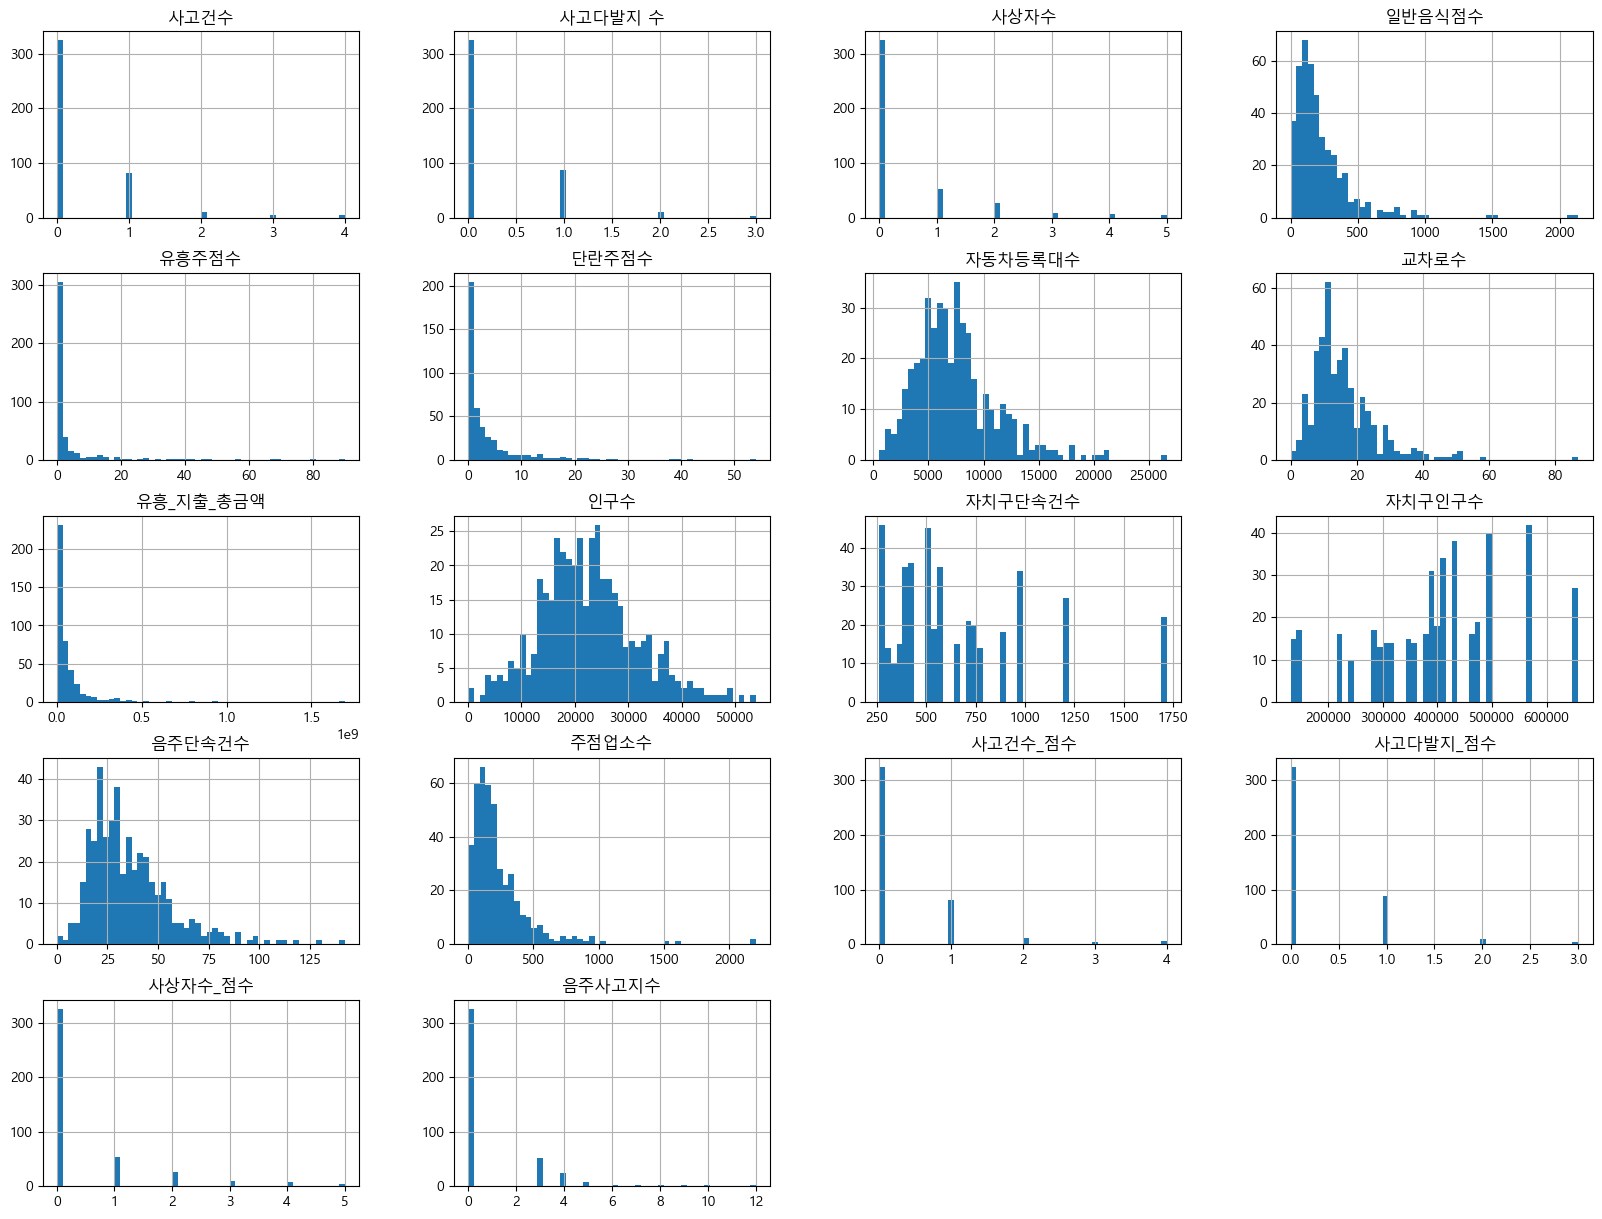

In [37]:
# 데이터 분포 확인
final_df.hist(bins=50, figsize=(20,15))
plt.show()

In [38]:
final_df.describe()

사고건수     사고다발지 수        사상자수       일반음식점수       유흥주점수  \
count  426.000000  426.000000  426.000000   426.000000  426.000000   
mean     0.316901    0.274648    0.438967   227.103286    3.971831   
std      0.682932    0.537677    0.966392   235.355928   11.011188   
min      0.000000    0.000000    0.000000     1.000000    0.000000   
25%      0.000000    0.000000    0.000000    95.250000    0.000000   
50%      0.000000    0.000000    0.000000   163.000000    0.000000   
75%      0.000000    0.000000    0.000000   283.000000    2.000000   
max      4.000000    3.000000    5.000000  2137.000000   90.000000   

            단란주점수       자동차등록대수        교차로수     유흥_지출_총금액           인구수  \
count  426.000000    426.000000  426.000000  4.260000e+02    426.000000   
mean     3.589202   7460.826291   15.856808  6.789617e+07  22547.931925   
std      6.116345   3706.918167    9.857844  1.284439e+08   9093.538921   
min      0.000000    545.000000    0.000000  0.000000e+00     60.000000   
25%      0.000000   4954.500000   10.000000  1.171725e+07  16493.000000   
50%      2.000000   6880.500000   13.000000  3.018450e+07  21841.000000   
75%      4.000000   8972.250000   20.000000  7.376350e+07  27643.000000   
max     54.000000  26665.000000   87.000000  1.694840e+09  53829.000000   

           자치구단속건수         자치구인구수      음주단속건수        주점업소수     사고건수_점수  \
count   426.000000     426.000000  426.000000   426.000000  426.000000   
mean    653.518779  402510.638498   36.058685   234.664319    0.316901   
std     356.289229  129525.715033   20.301857   244.986554    0.682932   
min     263.000000  131589.000000    0.067226     1.000000    0.000000   
25%     397.000000  319749.000000   21.811218    96.000000    0.000000   
50%     526.000000  412441.000000   30.787411   167.000000    0.000000   
75%     786.000000  496469.000000   44.926179   291.750000    0.000000   
max    1719.000000  657991.000000  142.054811  2202.000000    4.000000   

         사고다발지_점수     사상자수_점수      음주사고지수  
count  426.000000  426.000000  426.000000  
mean     0.274648    0.438967    1.030516  
std      0.537677    0.966392    2.143446  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      3.000000    5.000000   12.000000

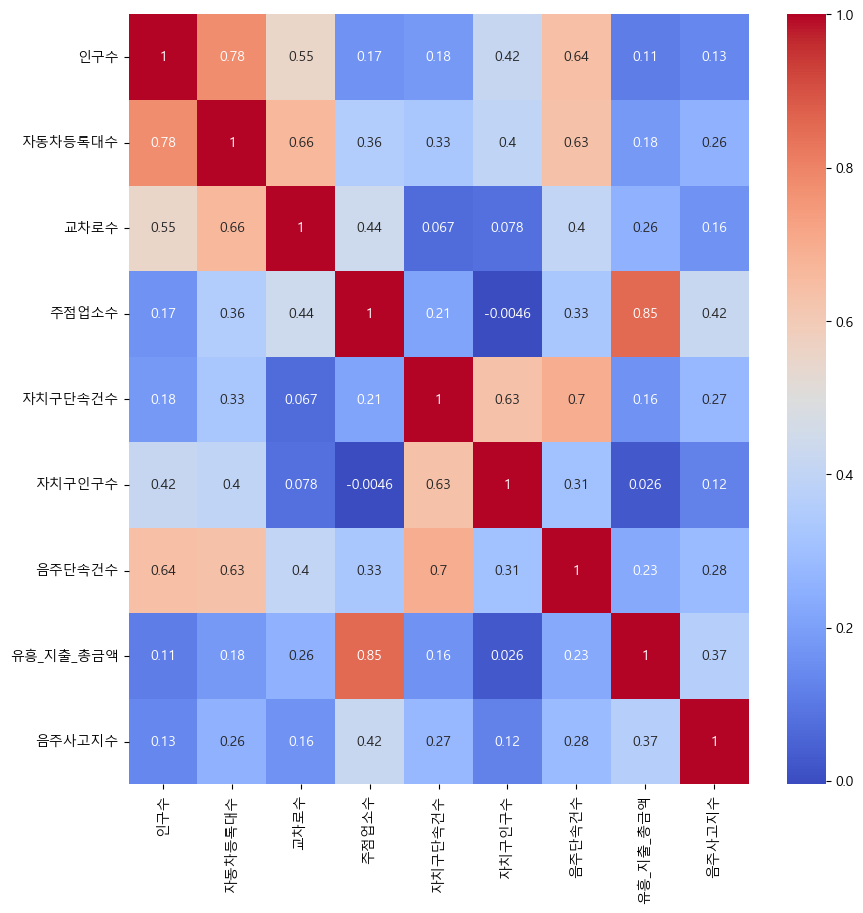

In [39]:
col = ['인구수', '자동차등록대수', '교차로수', '주점업소수', '자치구단속건수', '자치구인구수', '음주단속건수', '유흥_지출_총금액', '음주사고지수']

plt.figure(figsize = (10,10))
sns.heatmap(final_df[col].corr(), cmap= 'coolwarm', annot=True)
plt.show()

## 2-8. Scaling

In [40]:
final_df_2 = final_df.copy()

ss = StandardScaler()
final_df_2[col] = ss.fit_transform(final_df[col])

In [41]:
col = ['행정동명', '인구수', '자동차등록대수', '교차로수', '주점업소수', '자치구단속건수', '자치구인구수', '음주단속건수', '유흥_지출_총금액', '음주사고지수']
final_df_2 = final_df_2[col]
final_df_2 = final_df_2.set_index('행정동명')

# 3. Clustering

## 3-1. K Means

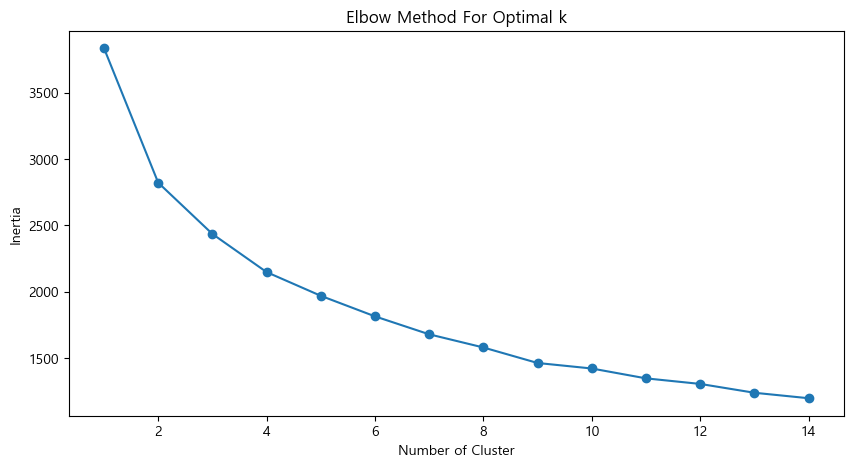

In [42]:
# 최적의 군집 개수 결정 (Elbow Method)
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df_2)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

최적의 군집 개수: 2


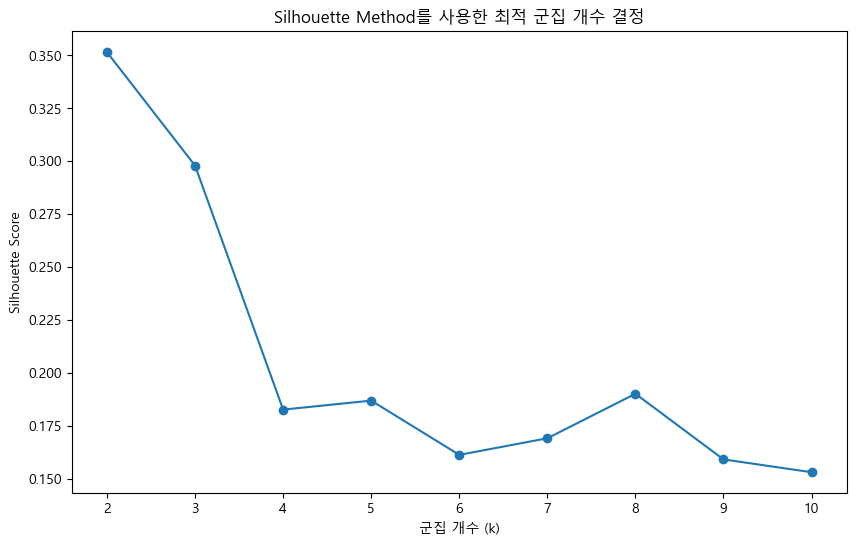

In [43]:
# 군집 개수 범위 설정
range_n_clusters = list(range(2, 11))

# Silhouette Score를 저장할 리스트 초기화
silhouette_avg = []

# 각 군집 개수에 대해 KMeans 클러스터링 수행 및 Silhouette Score 계산
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(final_df_2)

    # Silhouette Score 계산
    silhouette_avg.append(silhouette_score(final_df_2, cluster_labels))

# 최적의 군집 개수 찾기
optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# 결과 출력
print(f'최적의 군집 개수: {optimal_n_clusters}')

# Silhouette Score 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('군집 개수 (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method를 사용한 최적 군집 개수 결정')
plt.show()

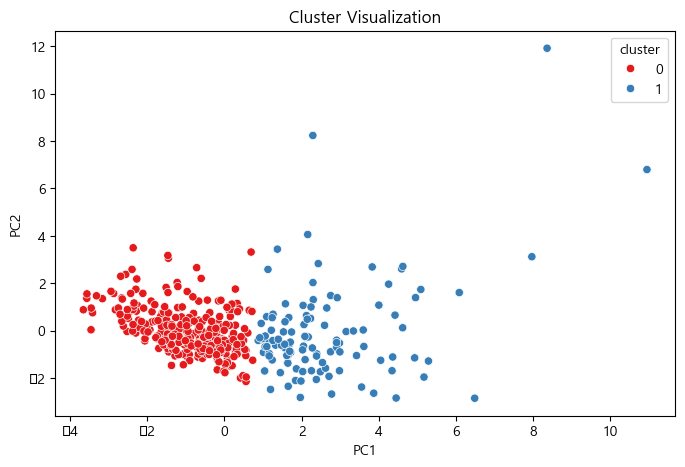

In [44]:
# 최적의 k 값 선택 후 K-means 적용
optimal_k = 2 # Elbow Method 결과를 바탕으로 선택
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_df_2['cluster'] = kmeans.fit_predict(final_df_2)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(final_df_2)
principal_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
principal_df['cluster'] = final_df_2['cluster'].values

plt.figure(figsize=(8, 5))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=principal_df, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster Visualization')
plt.show()

In [45]:
# 주성분 분산
print('주성분 분산: ', pca.explained_variance_)

# 주성분 계수
print('주성분 계수: ', np.round(pca.components_, 3))

# 주성분 분산 비율
print('주성분 분산 비율: ', pca.explained_variance_ratio_)

주성분 분산:  [3.94212254 1.79329154]
주성분 계수:  [[ 0.374  0.424  0.334  0.309  0.301  0.248  0.412  0.249  0.237  0.18 ]
 [-0.255 -0.154  0.084  0.539 -0.225 -0.395 -0.165  0.555  0.269 -0.013]]
주성분 분산 비율:  [0.42757157 0.19450448]


## 3-2. K Medoids

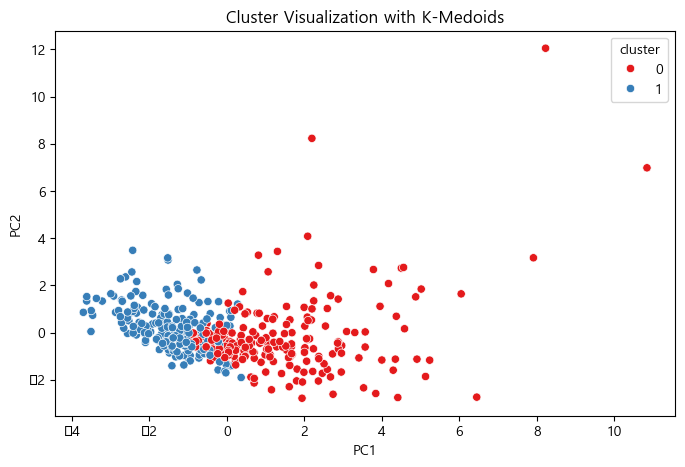

In [46]:
# K-Medoids 적용
optimal_k = 2  # 군집의 수를 지정
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
final_df_2['cluster'] = kmedoids.fit_predict(final_df_2)

# 군집 결과 시각화 (PCA 사용)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(final_df_2)
principal_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
principal_df['cluster'] = final_df_2['cluster'].values

plt.figure(figsize=(8, 5))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=principal_df, palette='Set1')
plt.title('Cluster Visualization with K-Medoids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3-3. GausianMixture

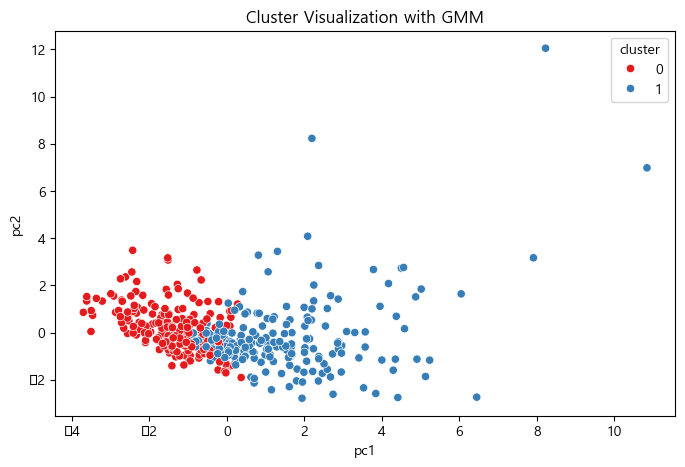

In [47]:
# GMM 적용
optimal_k = 2  # 군집의 수를 지정
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
final_df_2['cluster'] = gmm.fit_predict(final_df_2)

# 군집 결과 시각화 (PCA 사용)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(final_df_2)
principal_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
principal_df['cluster'] = final_df_2['cluster'].values

plt.figure(figsize=(8, 5))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=principal_df, palette='Set1')
plt.title('Cluster Visualization with GMM')
plt.show()

## 3-3. 요인별 Clustering

In [48]:
D = ['인구수', '자치구인구수', '음주단속건수']             # 인구요인
T = ['자동차등록대수', '교차로수', '음주단속건수']          # 교통요인
R = ['주점업소수','유흥_지출_총금액', '음주단속건수']       # 음주요인
RT = ['자치구단속건수', '음주사고지수', '음주단속건수']      # 음주관련교통요인

### 인구요인

최적의 군집 개수: 9


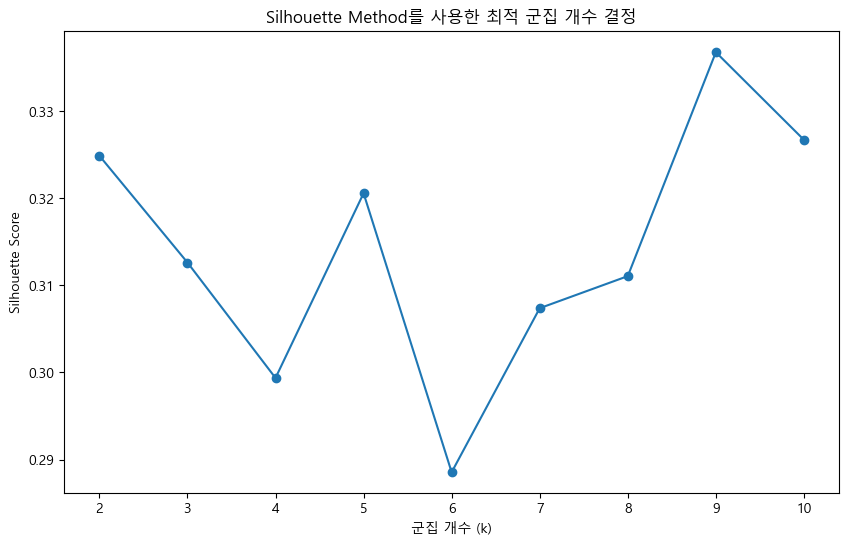

In [49]:
# 군집 개수 범위 설정
range_n_clusters = list(range(2, 11))

# Silhouette Score를 저장할 리스트 초기화
silhouette_avg = []

# 각 군집 개수에 대해 KMeans 클러스터링 수행 및 Silhouette Score 계산
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(final_df_2[D])

    # Silhouette Score 계산
    silhouette_avg.append(silhouette_score(final_df_2[D], cluster_labels))

# 최적의 군집 개수 찾기
optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# 결과 출력
print(f'최적의 군집 개수: {optimal_n_clusters}')

# Silhouette Score 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('군집 개수 (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method를 사용한 최적 군집 개수 결정')
plt.show()

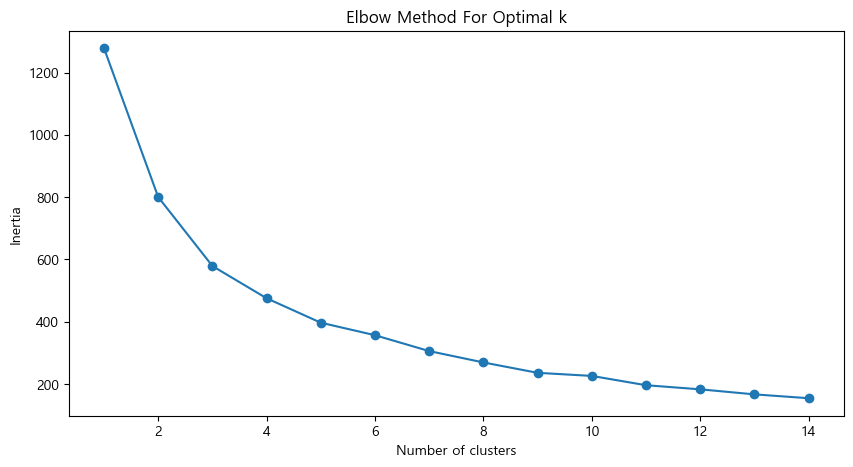

In [50]:
# 최적의 군집 개수 결정 (Elbow Method)
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df_2[D])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

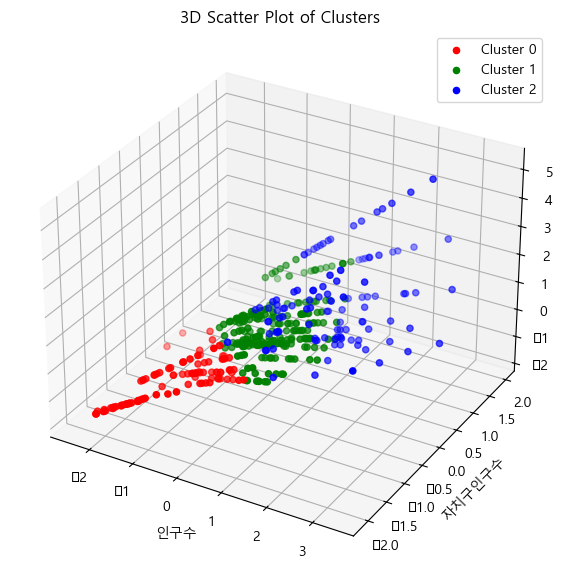

In [51]:
from mpl_toolkits.mplot3d import Axes3D

D_data = final_df_2[D]

# 최적의 k 값 선택 후 K-means 적용
optimal_k = 3 # Elbow Method 결과를 바탕으로 선택
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(D_data)
D_data['cluster'] = clusters

# 3차원 그래프 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 군집별 색상 지정
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in np.unique(clusters):
    cluster_data = D_data[D_data['cluster'] == cluster]
    ax.scatter(cluster_data['인구수'], cluster_data['자치구인구수'], cluster_data['음주단속건수'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('인구수')
ax.set_ylabel('자치구인구수')
ax.set_zlabel('음주단속건수')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [52]:
# 각 클러스터의 음주단속건수 평균 계산
cluster_means = D_data.groupby('cluster')['음주단속건수'].mean()

# 음주단속건수 평균이 가장 큰 클러스터 찾기
max_cluster = cluster_means.idxmax()

# 음주단속건수가 가장 큰 클러스터에 속한 행정동 찾기
D_indices_of_max_cluster = D_data[D_data['cluster'] == max_cluster].index.tolist()

# 각 클러스터에 속한 데이터 개수 계산
cluster_counts = D_data['cluster'].value_counts()

print(f"음주단속건수가 가장 큰 클러스터: {max_cluster}")
print(f"해당 클러스터에 속한 행정동: {D_indices_of_max_cluster}")
print("\n각 클러스터에 속한 데이터 개수:")
print(cluster_counts)

음주단속건수가 가장 큰 클러스터: 2
해당 클러스터에 속한 행정동: ['강남구 개포1동', '강남구 개포2동', '강남구 개포4동', '강남구 논현1동', '강남구 논현2동', '강남구 대치1동', '강남구 대치2동', '강남구 도곡1동', '강남구 도곡2동', '강남구 삼성2동', '강남구 세곡동', '강남구 압구정동', '강남구 역삼1동', '강남구 역삼2동', '강남구 일원본동', '강남구 청담동', '강동구 강일동', '강동구 길동', '강동구 상일제1동', '강동구 암사1동', '강동구 천호2동', '강북구 삼각산동', '강북구 송중동', '강북구 인수동', '강서구 가양1동', '강서구 공항동', '강서구 발산1동', '강서구 방화1동', '강서구 염창동', '강서구 우장산동', '강서구 화곡1동', '강서구 화곡본동', '관악구 미성동', '관악구 은천동', '관악구 청룡동', '관악구 행운동', '광진구 광장동', '광진구 구의2동', '광진구 구의3동', '광진구 자양3동', '광진구 중곡4동', '광진구 화양동', '구로구 개봉1동', '구로구 구로5동', '구로구 신도림동', '구로구 오류2동', '금천구 독산1동', '금천구 시흥1동', '노원구 공릉1동', '노원구 공릉2동', '노원구 상계1동', '노원구 중계2.3동', '동대문구 답십리1동', '동대문구 답십리2동', '동대문구 용신동', '동대문구 장안1동', '동대문구 장안2동', '동대문구 전농1동', '동대문구 제기동', '동대문구 휘경2동', '동작구 대방동', '동작구 상도1동', '마포구 공덕동', '마포구 상암동', '마포구 서강동', '마포구 서교동', '마포구 성산2동', '마포구 신수동', '마포구 아현동', '마포구 용강동', '서대문구 연희동', '서초구 반포1동', '서초구 반포2동', '서초구 반포3동', '서초구 서초2동', '서초구 서초3동', '서초구 서초4동', '서초구 양재1동', '서초구 잠원동', '성북구 길음1동', '성북구 석관동', '성북

In [53]:
cluster_means

cluster
0   -0.680600
1   -0.305946
2    1.209127
Name: 음주단속건수, dtype: float64

### 교통요인

최적의 군집 개수: 2


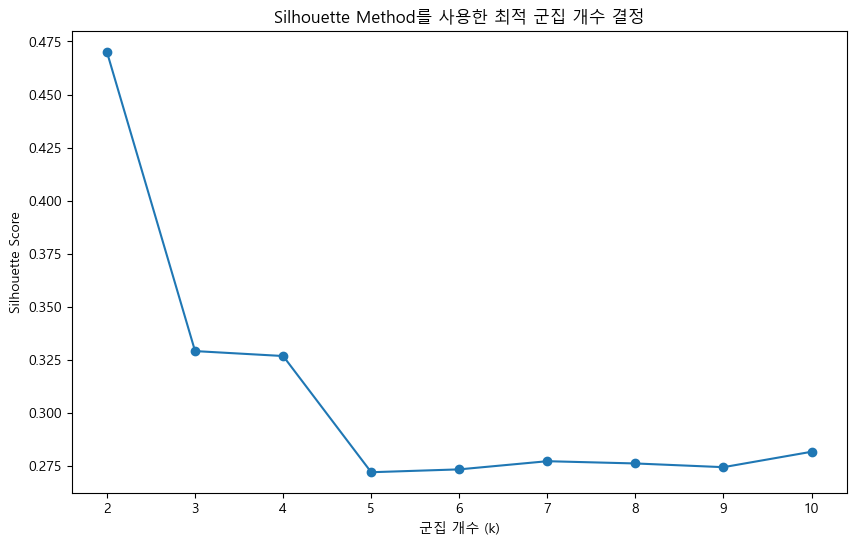

In [54]:
# 군집 개수 범위 설정
range_n_clusters = list(range(2, 11))

# Silhouette Score를 저장할 리스트 초기화
silhouette_avg = []

# 각 군집 개수에 대해 KMeans 클러스터링 수행 및 Silhouette Score 계산
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(final_df_2[T])

    # Silhouette Score 계산
    silhouette_avg.append(silhouette_score(final_df_2[T], cluster_labels))

# 최적의 군집 개수 찾기
optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# 결과 출력
print(f'최적의 군집 개수: {optimal_n_clusters}')

# Silhouette Score 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('군집 개수 (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method를 사용한 최적 군집 개수 결정')
plt.show()

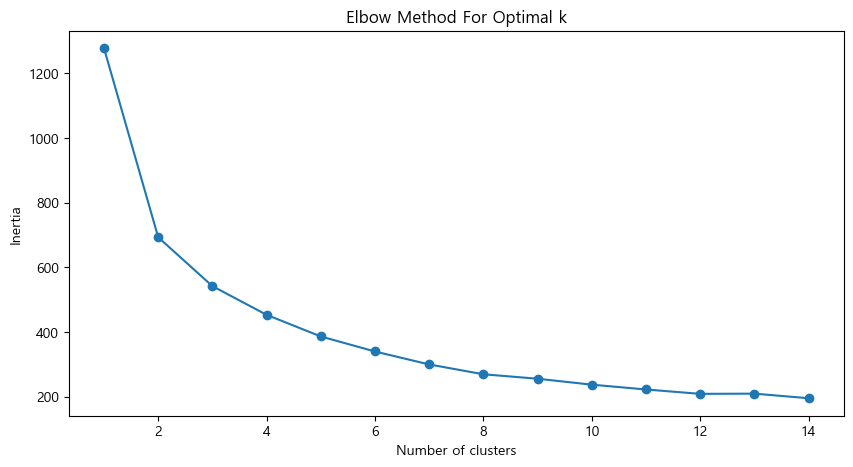

In [55]:
# 최적의 군집 개수 결정 (Elbow Method)
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df_2[T])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

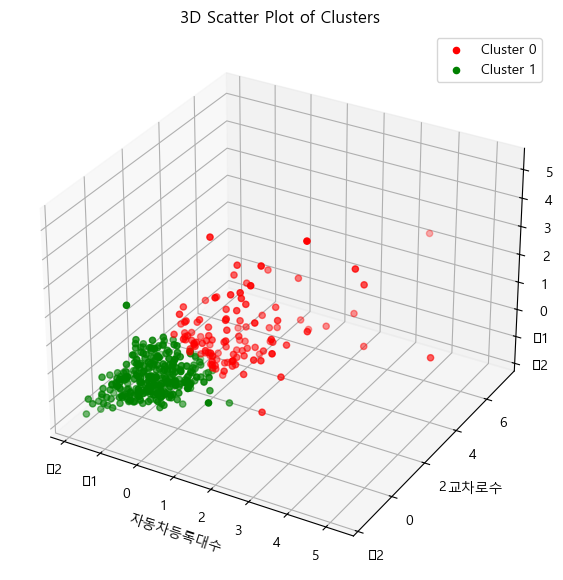

In [56]:
T_data = final_df_2[T]

# 최적의 k 값 선택 후 K-means 적용
optimal_k = 2 # Elbow Method 결과를 바탕으로 선택
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(T_data)
T_data['cluster'] = clusters

# 3차원 그래프 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 군집별 색상 지정
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in np.unique(clusters):
    cluster_data = T_data[T_data['cluster'] == cluster]
    ax.scatter(cluster_data['자동차등록대수'], cluster_data['교차로수'], cluster_data['음주단속건수'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('자동차등록대수')
ax.set_ylabel('교차로수')
ax.set_zlabel('음주단속건수')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [57]:
# 각 클러스터의 음주단속건수 평균 계산
cluster_means = T_data.groupby('cluster')['음주단속건수'].mean()

# 음주단속건수 평균이 가장 큰 클러스터 찾기
max_cluster = cluster_means.idxmax()

# 음주단속건수가 가장 큰 클러스터에 속한 행정동 찾기
T_indices_of_max_cluster = T_data[T_data['cluster'] == max_cluster].index.tolist()

# 각 클러스터에 속한 데이터 개수 계산
cluster_counts = T_data['cluster'].value_counts()

print(f"음주단속건수가 가장 큰 클러스터: {max_cluster}")
print(f"해당 클러스터에 속한 행정동: {T_indices_of_max_cluster}")
print("\n각 클러스터에 속한 데이터 개수:")
print(cluster_counts)

음주단속건수가 가장 큰 클러스터: 0
해당 클러스터에 속한 행정동: ['강남구 개포2동', '강남구 개포4동', '강남구 논현1동', '강남구 논현2동', '강남구 대치1동', '강남구 대치2동', '강남구 대치4동', '강남구 도곡1동', '강남구 도곡2동', '강남구 삼성1동', '강남구 삼성2동', '강남구 세곡동', '강남구 압구정동', '강남구 역삼1동', '강남구 역삼2동', '강남구 일원본동', '강남구 청담동', '강동구 강일동', '강동구 길동', '강동구 상일제1동', '강동구 천호2동', '강북구 삼각산동', '강북구 송중동', '강북구 인수동', '강서구 가양1동', '강서구 공항동', '강서구 등촌3동', '강서구 발산1동', '강서구 방화1동', '강서구 방화2동', '강서구 염창동', '강서구 우장산동', '강서구 화곡1동', '관악구 청룡동', '광진구 광장동', '광진구 구의3동', '광진구 자양3동', '구로구 개봉1동', '구로구 구로1동', '구로구 구로2동', '구로구 구로3동', '구로구 구로5동', '구로구 신도림동', '구로구 오류2동', '금천구 가산동', '금천구 독산1동', '금천구 시흥1동', '노원구 공릉1동', '노원구 공릉2동', '노원구 상계1동', '노원구 상계6.7동', '노원구 중계2.3동', '도봉구 방학1동', '동대문구 답십리1동', '동대문구 답십리2동', '동대문구 용신동', '동대문구 장안1동', '동대문구 장안2동', '동대문구 전농1동', '동대문구 제기동', '동작구 노량진1동', '동작구 대방동', '동작구 상도1동', '동작구 흑석동', '마포구 공덕동', '마포구 상암동', '마포구 서강동', '마포구 서교동', '마포구 성산2동', '마포구 신수동', '마포구 아현동', '마포구 용강동', '서대문구 연희동', '서초구 내곡동', '서초구 반포1동', '서초구 반포3동', '서초구 방배4동', '서초구 서초1동', '서초구 서초2동', '서초구 서초3동', '서초구 서초4동'

In [58]:
cluster_means

cluster
0    1.075443
1   -0.412020
Name: 음주단속건수, dtype: float64

### 음주요인

최적의 군집 개수: 2


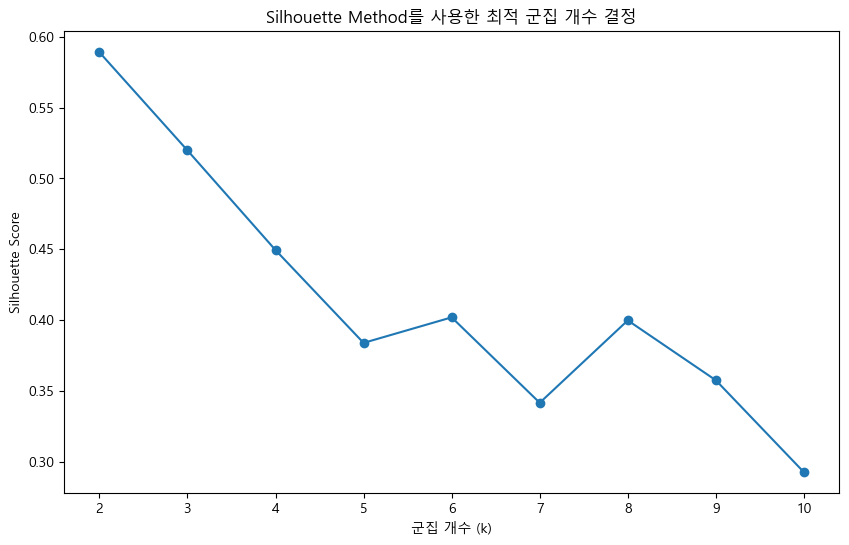

In [59]:
# 군집 개수 범위 설정
range_n_clusters = list(range(2, 11))

# Silhouette Score를 저장할 리스트 초기화
silhouette_avg = []

# 각 군집 개수에 대해 KMeans 클러스터링 수행 및 Silhouette Score 계산
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(final_df_2[R])

    # Silhouette Score 계산
    silhouette_avg.append(silhouette_score(final_df_2[R], cluster_labels))

# 최적의 군집 개수 찾기
optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# 결과 출력
print(f'최적의 군집 개수: {optimal_n_clusters}')

# Silhouette Score 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('군집 개수 (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method를 사용한 최적 군집 개수 결정')
plt.show()

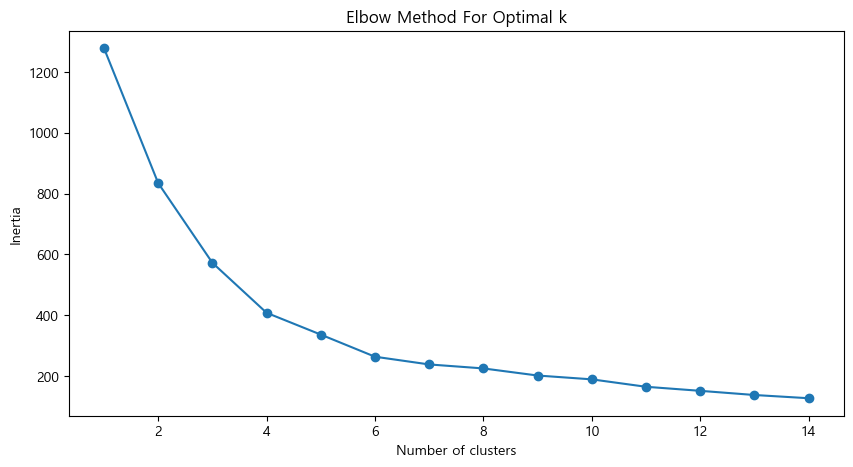

In [60]:
# 최적의 군집 개수 결정 (Elbow Method)
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df_2[R])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

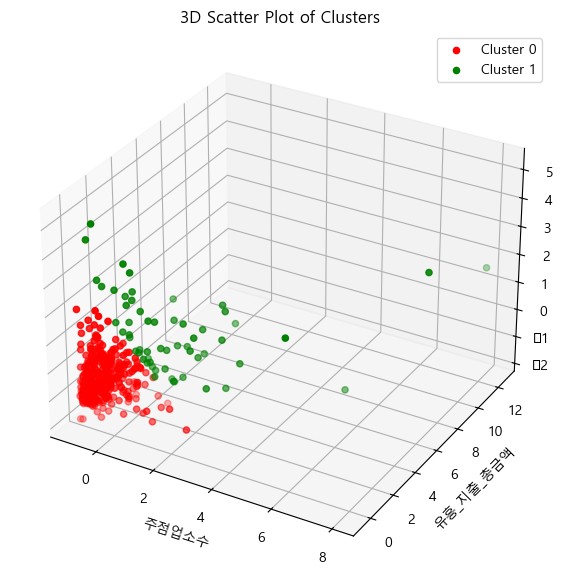

In [61]:
R_data = final_df_2[R]

# 최적의 k 값 선택 후 K-means 적용
optimal_k = 2 # Elbow Method 결과를 바탕으로 선택
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(R_data)
R_data['cluster'] = clusters

# 3차원 그래프 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 군집별 색상 지정
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in np.unique(clusters):
    cluster_data = R_data[R_data['cluster'] == cluster]
    ax.scatter(cluster_data['주점업소수'], cluster_data['유흥_지출_총금액'], cluster_data['음주단속건수'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('주점업소수')
ax.set_ylabel('유흥_지출_총금액')
ax.set_zlabel('음주단속건수')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [62]:
# 각 클러스터의 음주단속건수 평균 계산
cluster_means = R_data.groupby('cluster')['음주단속건수'].mean()

# 음주단속건수 평균이 가장 큰 클러스터 찾기
max_cluster = cluster_means.idxmax()

# 음주단속건수가 가장 큰 클러스터에 속한 행정동 찾기
R_indices_of_max_cluster = R_data[R_data['cluster'] == max_cluster].index.tolist()

# 각 클러스터에 속한 데이터 개수 계산
cluster_counts = R_data['cluster'].value_counts()

print(f"음주단속건수가 가장 큰 클러스터: {max_cluster}")
print(f"해당 클러스터에 속한 행정동: {R_indices_of_max_cluster}")
print("\n각 클러스터에 속한 데이터 개수:")
print(cluster_counts)

음주단속건수가 가장 큰 클러스터: 1
해당 클러스터에 속한 행정동: ['강남구 개포2동', '강남구 논현1동', '강남구 논현2동', '강남구 대치2동', '강남구 대치4동', '강남구 도곡2동', '강남구 삼성1동', '강남구 삼성2동', '강남구 세곡동', '강남구 신사동', '강남구 압구정동', '강남구 역삼1동', '강남구 역삼2동', '강남구 청담동', '강동구 길동', '강동구 천호2동', '강북구 송중동', '강북구 수유3동', '강서구 가양1동', '강서구 화곡1동', '관악구 서원동', '관악구 신림동', '광진구 화양동', '구로구 구로3동', '금천구 가산동', '금천구 독산1동', '노원구 상계2동', '동대문구 용신동', '동대문구 장안1동', '동대문구 장안2동', '동대문구 전농1동', '마포구 공덕동', '마포구 상암동', '마포구 서강동', '마포구 서교동', '마포구 성산2동', '마포구 연남동', '마포구 합정동', '서대문구 신촌동', '서초구 서초2동', '서초구 서초3동', '서초구 서초4동', '서초구 양재1동', '서초구 잠원동', '송파구 가락본동', '송파구 문정2동', '송파구 방이2동', '송파구 석촌동', '송파구 잠실본동', '영등포구 당산1동', '영등포구 당산2동', '영등포구 문래동', '영등포구 여의동', '영등포구 영등포동', '용산구 이태원1동', '용산구 한강로동', '용산구 한남동', '종로구 종로1.2.3.4가동']

각 클러스터에 속한 데이터 개수:
cluster
0    368
1     58
Name: count, dtype: int64


### 음주관련교통요인

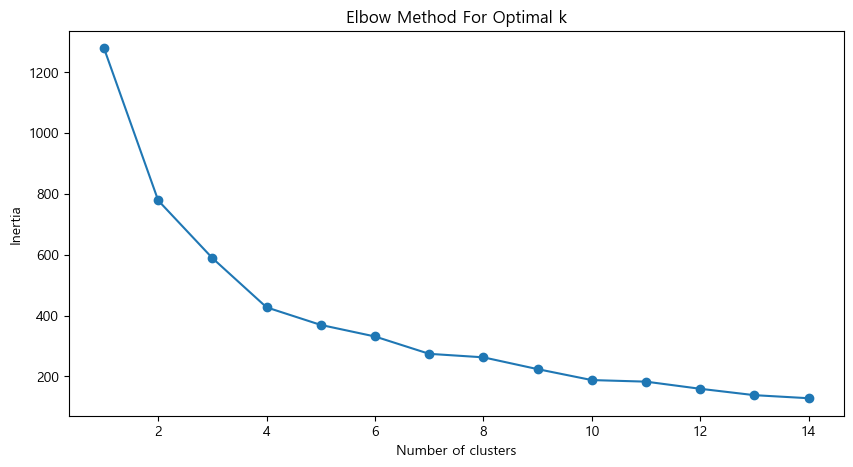

In [63]:
# 최적의 군집 개수 결정 (Elbow Method)
inertia = []
k_range = range(1, 15)
RT_data = final_df_2[RT]

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RT_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

최적의 군집 개수: 2


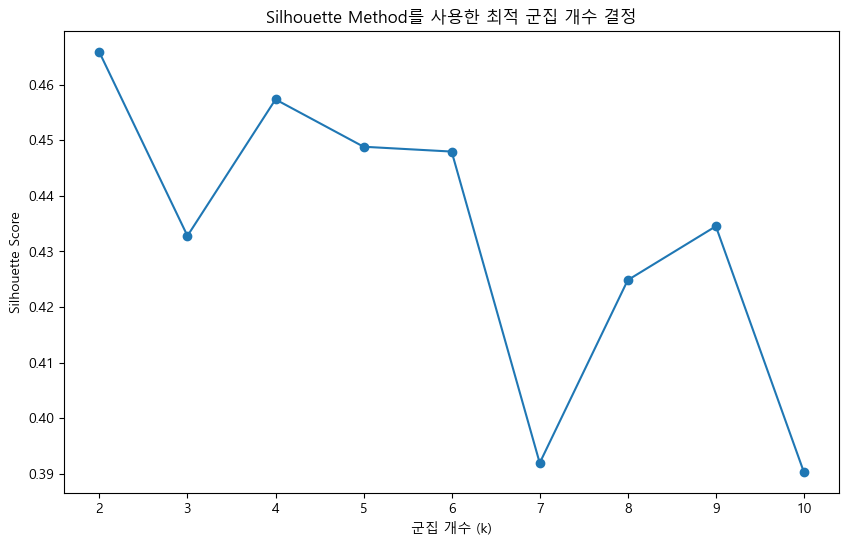

In [64]:
# 군집 개수 범위 설정
range_n_clusters = list(range(2, 11))

# Silhouette Score를 저장할 리스트 초기화
silhouette_avg = []

# 각 군집 개수에 대해 KMeans 클러스터링 수행 및 Silhouette Score 계산
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(final_df_2[RT])

    # Silhouette Score 계산
    silhouette_avg.append(silhouette_score(final_df_2[RT], cluster_labels))

# 최적의 군집 개수 찾기
optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# 결과 출력
print(f'최적의 군집 개수: {optimal_n_clusters}')

# Silhouette Score 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('군집 개수 (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method를 사용한 최적 군집 개수 결정')
plt.show()

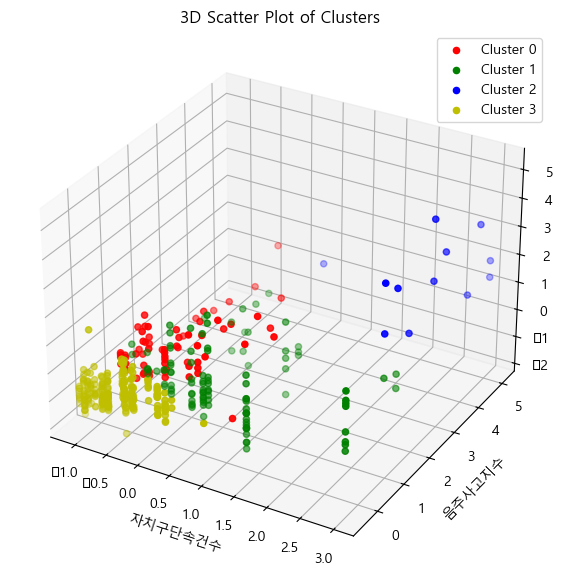

In [65]:
RT_data = final_df_2[RT]

# 최적의 k 값 선택 후 K-means 적용
optimal_k = 4 # Elbow Method 결과를 바탕으로 선택
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(RT_data)
RT_data['cluster'] = clusters

# 3차원 그래프 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 군집별 색상 지정
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in np.unique(clusters):
    cluster_data = RT_data[RT_data['cluster'] == cluster]
    ax.scatter(cluster_data['자치구단속건수'], cluster_data['음주사고지수'], cluster_data['음주단속건수'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('자치구단속건수')
ax.set_ylabel('음주사고지수')
ax.set_zlabel('음주단속건수')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [66]:
# 각 클러스터의 음주단속건수 평균 계산
cluster_means = RT_data.groupby('cluster')['음주단속건수'].mean()

# 음주단속건수 평균이 가장 큰 클러스터 찾기
max_cluster = cluster_means.idxmax()

# 음주단속건수가 가장 큰 클러스터에 속한 행정동 찾기
RT_indices_of_max_cluster = RT_data[RT_data['cluster'] == max_cluster].index.tolist()

# 각 클러스터에 속한 데이터 개수 계산
cluster_counts = RT_data['cluster'].value_counts()

print(f"음주단속건수가 가장 큰 클러스터: {max_cluster}")
print(f"해당 클러스터에 속한 행정동: {RT_indices_of_max_cluster}")
print("\n각 클러스터에 속한 데이터 개수:")
print(cluster_counts)

음주단속건수가 가장 큰 클러스터: 2
해당 클러스터에 속한 행정동: ['강남구 개포2동', '강남구 논현1동', '강남구 논현2동', '강남구 대치2동', '강남구 도곡2동', '강남구 삼성2동', '강남구 세곡동', '강남구 압구정동', '강남구 역삼1동', '강남구 역삼2동', '강남구 청담동', '마포구 서교동']

각 클러스터에 속한 데이터 개수:
cluster
3    238
1    108
0     68
2     12
Name: count, dtype: int64


In [67]:
all = D_indices_of_max_cluster + T_indices_of_max_cluster + R_indices_of_max_cluster + RT_indices_of_max_cluster
cnt = Counter(all)
three = [element for element, count in cnt.items() if count >= 3]
four = [element for element, count in cnt.items() if count >= 4]

print(set(three) - set(four)) # 위험지역 
print(four)                   # 고위험지역

{'영등포구 영등포동', '동대문구 용신동', '송파구 잠실본동', '마포구 상암동', '서초구 서초2동', '동대문구 장안1동', '영등포구 문래동', '강서구 화곡1동', '서초구 양재1동', '서초구 서초4동', '마포구 성산2동', '마포구 공덕동', '강동구 천호2동', '강북구 송중동', '서초구 잠원동', '송파구 문정2동', '송파구 석촌동', '서초구 서초3동', '강서구 가양1동', '영등포구 여의동', '강동구 길동', '금천구 독산1동', '영등포구 당산2동', '동대문구 장안2동', '동대문구 전농1동', '마포구 서강동'}
['강남구 개포2동', '강남구 논현1동', '강남구 논현2동', '강남구 대치2동', '강남구 도곡2동', '강남구 삼성2동', '강남구 세곡동', '강남구 압구정동', '강남구 역삼1동', '강남구 역삼2동', '강남구 청담동', '마포구 서교동']


In [68]:
three

['강남구 개포2동',
 '강남구 논현1동',
 '강남구 논현2동',
 '강남구 대치2동',
 '강남구 도곡2동',
 '강남구 삼성2동',
 '강남구 세곡동',
 '강남구 압구정동',
 '강남구 역삼1동',
 '강남구 역삼2동',
 '강남구 청담동',
 '강동구 길동',
 '강동구 천호2동',
 '강북구 송중동',
 '강서구 가양1동',
 '강서구 화곡1동',
 '금천구 독산1동',
 '동대문구 용신동',
 '동대문구 장안1동',
 '동대문구 장안2동',
 '동대문구 전농1동',
 '마포구 공덕동',
 '마포구 상암동',
 '마포구 서강동',
 '마포구 서교동',
 '마포구 성산2동',
 '서초구 서초2동',
 '서초구 서초3동',
 '서초구 서초4동',
 '서초구 양재1동',
 '서초구 잠원동',
 '송파구 문정2동',
 '송파구 석촌동',
 '송파구 잠실본동',
 '영등포구 당산2동',
 '영등포구 문래동',
 '영등포구 여의동',
 '영등포구 영등포동']

# Map

In [69]:
seoul_accident_df['지점코드'] = seoul_accident_df['지점코드'].astype(str)
seoul_accident_df = seoul_accident_df[seoul_accident_df['지점코드'].str.startswith('11')]

In [70]:
m3 = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

for _, row in seoul_dong_boundary_geojson.iterrows():
    dong_name = row['temp']
    if dong_name in four: # 음주운전 고위험 지역
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 2, 'fillOpacity': 0.65},
            tooltip=dong_name
        ).add_to(m3)
    elif dong_name in three: # 음주운전 위험 지역
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x: {'fillColor': 'orange', 'color': 'orange', 'weight': 2, 'fillOpacity': 0.65},
            tooltip=dong_name
        ).add_to(m3)
    else:                    # 기타 행정동
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x: {'fillColor': 'grey', 'color': 'grey', 'weight': 1, 'fillOpacity': 0.5},
            tooltip=dong_name
        ).add_to(m3)

for _, row in seoul_accident_df.iterrows():
    folium.Marker(
        location=[row['위도'], row['경도']],
        popup=folium.Popup(html=f"<div style='white-space: nowrap;'>{row['지점명']}</div>"),
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(m3)
    
m3

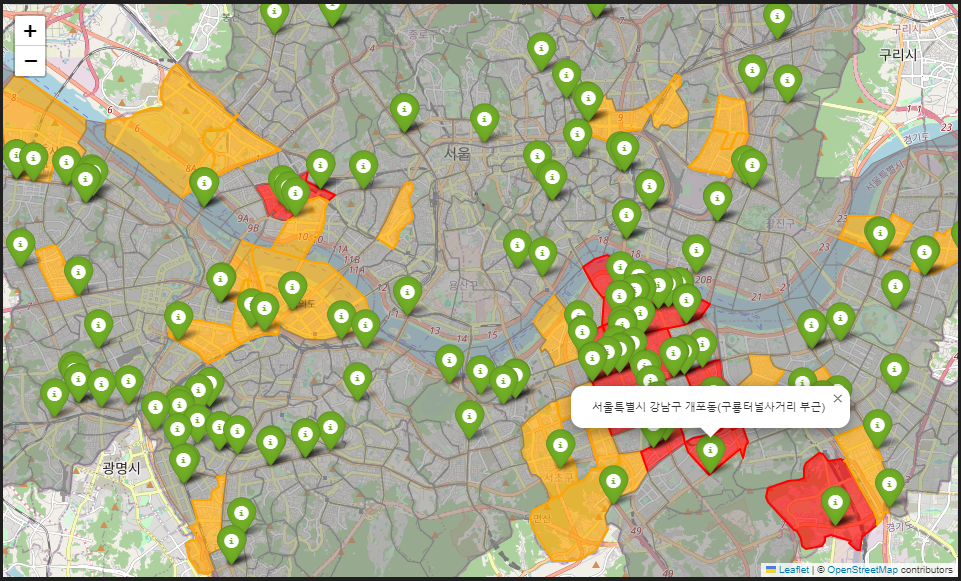